In [1]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt

from db_utils.db_connection import SumatraDB

## Load model

In [25]:
DATA_PATH="../data"
RECORD_LABEL="20180606-104310"
RECORD_PATH=os.path.join(DATA_PATH, RECORD_LABEL)


# Query config from database
db = SumatraDB(db="../.smt/records")
COLUMNS = ["label", "reason", "timestamp", "tags", "parameters_id", "version"]
record = db.get_filtered_by_label(COLUMNS, RECORD_LABEL)[0]
config = db.get_params_dic(record.params_id)

# Create folder for generated plots
if not os.path.exists("generated_plots"):
    os.mkdir("generated_plots")

config

{'class': 'src.test_retest.mri.unsupervised_features.PCAAutoEncoderTuples',
 'params': {'config': {'keep_checkpoint_max': 1,
   'log_step_count_steps': 100,
   'save_checkpoints_steps': 200,
   'save_summary_steps': 1,
   'tf_random_seed': 42},
  'data_params': {'dump_out_dir': 'produced_data', 'not_needed': 'not'},
  'hooks': {'confusion_matrix': True, 'icc_c1': True},
  'input_fn_config': {'batch_size': 4, 'num_epochs': 5, 'shuffle': None},
  'params': {'hidden_dim': 128,
   'hidden_lambda': 0,
   'hidden_regularizer': 'js_divergence',
   'input_dim': 902629,
   'lambda_w': 0,
   'learning_rate': 0.001,
   'n_classes': 10,
   'weight_regularizer': 'l2'},
  'streamer': {'class': 'src.data.streaming.mri_streaming.MRISamePatientSameAgePairStream',
   'params': {'stream_config': {'balanced_labels': ['healthy', 'health_ad'],
     'batch_size': 16,
     'data_sources': [{'glob_pattern': '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz',
       'id_from_filename': {'regex_id_gr

In [26]:
import importlib
# Load python class to construct object
def import_class(full_path):
    module_string = ".".join(full_path.split(".")[:-1])
    module = importlib.import_module(module_string)
    class_ = getattr(module, full_path.split(".")[-1])
    return class_
    
class_ = import_class(config["class"])
# Don't need streamer
s_class = config["params"]["streamer"]["class"]
s_class = import_class(s_class)
s_params = config["params"]["streamer"]["params"]
print(s_params)
csv_path = config["params"]["streamer"]["params"]["stream_config"]["meta_csv"]
config["params"]["streamer"]["params"]["stream_config"]["meta_csv"] = "../" + csv_path
streamer = s_class(**s_params)

config["params"]["streamer"] = None
obj = class_(**config["params"])

{'stream_config': {'balanced_labels': ['healthy', 'health_ad'], 'batch_size': 16, 'data_sources': [{'glob_pattern': '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz', 'id_from_filename': {'regex_id_group': 1, 'regexp': '.*/([AI0-9]+)_mni_aligned\\.nii\\.gz'}, 'name': 'ADNI_AIBL'}], 'downsample': {'enabled': False, 'shape': [28, 28]}, 'feature_collection': 'adni_aibl', 'meta_csv': 'data/raw/csv/adni_aibl__ad_hc.csv', 'meta_id_column': 'image_label', 'prefetch': 4, 'seed': 47, 'shuffle': True, 'train_ratio': 0.8}}


/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/103017_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/474676_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/57208_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/43116_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/367200_aug_mni_aligned.nii.gz
  .format(p))
/l

/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/342681_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/141448_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/29251_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/280220_aug_mni_aligned.nii.gz
  .format(p))
/local/home/mhoerold/entrack/src/data/streaming/base.py:479: UserWarning: Could note extract id from path /local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/109281_aug_mni_aligned.nii.gz
  .format(p))
/

ADNI_AIBL has 20092 files
8998 files found but not specified meta csv
Number of files: 11094
Number of files missing: 0
Achieved train ratio: 0.7996398018910401
>>>>>>>>> Sanity checks OK
>>>>>>>> Train stats
>>>>>>>>>>>>>>>>
>>>> Age stats, mean=75.47484984984985, std=6.6938722745886015
>>>> Age diffences stats, mean=0.0, std=0.0
>>>> healthy count: 6032
>>>> health_ad count: 4624
>>>>>>>>>>>>>>>>
>>>>>>>> Test stats
>>>>>>>>>>>>>>>>
>>>> Age stats, mean=75.75131086142322, std=7.304989583392815
>>>> Age diffences stats, mean=0.0, std=0.0
>>>> healthy count: 1520
>>>> health_ad count: 1150
>>>>>>>>>>>>>>>>


/local/home/mhoerold/entrack/src/data/streaming/mri_streaming.py:171: UserWarning: 11094 files not found
  warnings.warn("{} files not found".format(not_found))


In [27]:
# Construct estimator
est = tf.estimator.Estimator(
    model_fn=obj.model_fn,
    model_dir=RECORD_PATH,
    params=config["params"]["params"]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../data/20180606-104310', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4f4c205630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Analyze PCA transformation

In [6]:
W = est.get_variable_value('weights')

In [7]:
W.shape  # columns are principal components

(902629, 128)

In [48]:
W.dtype

dtype('float32')

float32


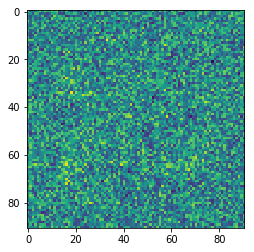

In [79]:
component = 0
image_shape = (91, 109, 91)
principal_vec = W[:, component]
vec_as_image = np.reshape(principal_vec, image_shape)
print(vec_as_image.dtype)
plt.imshow(vec_as_image[:, 55, :])

#### Reconstruct an image

In [50]:
image_label = "166821"
embedding_path = os.path.join("..", "produced_data", RECORD_LABEL, "test_4", image_label + "_mni_aligned.npy")
embedding = np.load(embedding_path)
embedding.dtype

dtype('float32')

In [51]:
reconstruction = np.matmul(np.reshape(embedding, (1, -1)), W.T)
reconstruction.dtype

dtype('float32')

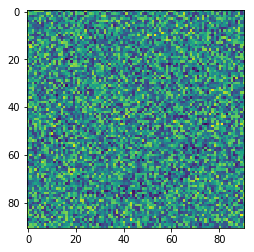

In [43]:
rec_image = np.reshape(reconstruction, image_shape)
plt.imshow(vec_as_image[:, 50, :])

In [44]:
# original image
import nibabel as nib

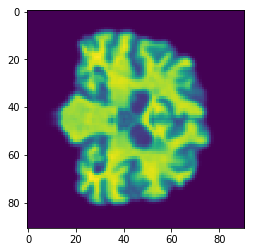

In [45]:
path = "/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/" + image_label + "_mni_aligned.nii.gz"
orig_im = nib.load(path).get_data()
orig_im = np.reshape(orig_im, image_shape)
plt.imshow(orig_im[:, 50, :])

In [14]:
np.linalg.norm(orig_im - rec_image)

27949.06

### Compute test_loss

In [15]:
test_folder = os.path.join("..", "produced_data", RECORD_LABEL, "test_4")

In [16]:
files = os.listdir(test_folder)

In [17]:
files[:5]

['300744_mni_aligned.npy',
 '129028_mni_aligned.npy',
 '253758_mni_aligned.npy',
 '266209_mni_aligned.npy',
 '28302_mni_aligned.npy']

In [18]:
c = 0
loss = 0
maxi = 100
for test_file in files:
    c += 1
    if c > maxi:
        break
    # compute reconstruction
    image_label = test_file.split("_")[0]
    embedding_path = os.path.join(test_folder, image_label + "_mni_aligned.npy")
    embedding = np.load(embedding_path)
    reconstruction = np.matmul(np.reshape(embedding, (1, -1)), W.T)
    rec_image = np.reshape(reconstruction, image_shape)
    # load original
    path = "/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/" + image_label + "_mni_aligned.nii.gz"
    orig_im = nib.load(path).get_data()
    orig_im = np.reshape(orig_im, image_shape)
    
    loss += np.sum((rec_image - orig_im) ** 2) / maxi
    
print(loss)

5692822041.720001


In [19]:
## Use tf to compute reconstruction

In [28]:
preds = est.predict(streamer.get_input_fn(False))

In [29]:
c = 0
for pred in preds:
    c += 1
    if c > 2:
        break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../data/20180606-104310/model.ckpt-1665
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [30]:
pred

{'hidden_rep': array([  7030.7485  ,   7897.152   ,   8304.781   ,  -7580.936   ,
          8098.4053  , -13674.594   ,  11311.576   ,    144.76427 ,
         -2418.8367  ,  -6588.547   ,   8156.8486  ,  -4367.9253  ,
         -3833.651   ,  -6372.072   ,  11485.027   ,   7656.7544  ,
          -849.7842  ,  -6840.1904  ,   5181.1704  ,  -7498.298   ,
         -3614.1138  ,   5252.284   ,   7270.0967  ,  -8252.203   ,
           230.22028 ,   3912.4539  ,   6965.488   ,  10624.486   ,
         10082.854   ,  -7571.0405  ,  -1588.9576  ,  -2323.2588  ,
          -862.2197  ,  -9611.026   ,  10372.273   , -11125.551   ,
          5041.062   ,  -5148.3154  ,   1023.31134 , -10805.298   ,
         -4916.657   , -12086.01    ,   4526.1455  ,     79.612915,
         -2335.5918  ,  -5349.036   ,  -5874.6963  ,   4124.201   ,
        -12425.931   ,   6185.306   ,  -7487.045   ,  -1189.127   ,
         -9009.726   ,  -3551.3958  ,  11040.179   ,  -7294.5825  ,
         -8744.68    ,    -85.5830

In [31]:
reco = pred["reconstruction"]

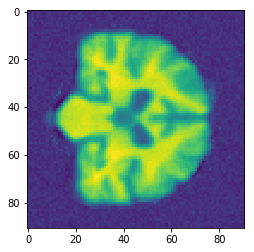

In [32]:
reco = np.reshape(reco, image_shape)
plt.imshow(reco[:, 50, :])

In [33]:
pred.keys()

dict_keys(['hidden_rep', 'reconstruction', 'file_name'])

In [37]:
inp = np.reshape(pred["input"], image_shape)
plt.imshow(inp[:, 50, :])

KeyError: 'input'

In [38]:
np.sum((reco - inp) ** 2) / (91 * 109 * 91)

NameError: name 'inp' is not defined

In [39]:
image_shape

(91, 109, 91)

In [40]:
pred["file_name"]

array([b'166821_mni_aligned'], dtype=object)

In [46]:
reconstruction - pred["reconstruction"]

array([[ 7.6293945e-06,  3.0517578e-05,  1.9073486e-05, ...,
         3.8146973e-06,  0.0000000e+00, -3.8146973e-06]], dtype=float32)

In [47]:
np.sum(reconstruction - pred["reconstruction"])

-0.01072377

In [52]:
hidden = pred["hidden_rep"]

In [53]:
hidden.shape

(128,)

In [54]:
hidden_rec = np.matmul(np.reshape(hidden, (1, -1)), W.T)

In [55]:
hidden_rec = np.reshape(hidden_rec, image_shape)

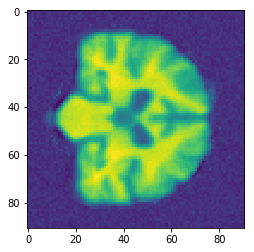

In [56]:
plt.imshow(hidden_rec[:, 50, :])

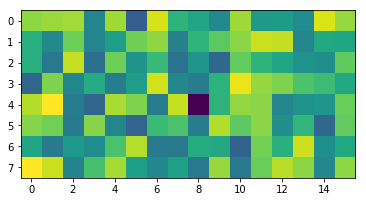

In [62]:
plt.imshow(np.reshape(hidden, (8, -1)))

In [63]:
np.max(hidden)

13741.131

In [64]:
np.min(hidden)

-25357.043

In [65]:
np.mean(hidden)

-300.56155

In [71]:
principals = np.reshape(W, (-1, *image_shape))

In [72]:
principals.shape

(128, 91, 109, 91)

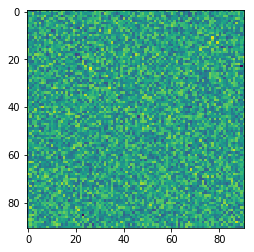

In [73]:
p = principals[0]
plt.imshow(p[:, 50, :])